# Data Prep & Modeling
## Filtering

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
assert pd.__version__ >= '1.5', "Upgrade Pandas to 1.5+"
import numpy as np
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

marte_raw = pd.read_csv('marte_vs_nlwest_19_22.csv',
                        usecols=['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'pitcher', 'zone', 'des', 'p_throws', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'iso_value', 'launch_speed_angle', 'pitch_name'])

# rename the primary response variable
marte_raw.rename(columns={'estimated_woba_using_speedangle': 'xwOBA'}, inplace=True)
print(f"data-set shape prior to filtering: {marte_raw.shape}")

# filter sacrifice events; if woba_denom is NaN, then sacrifice event
# filter walks and strikeout events
marte_raw.dropna(axis='rows', subset=['woba_denom', 'xwOBA'], how='any', inplace=True)
print(f"data-set shape after to filtering sac hits, walks, strikeouts: {marte_raw.shape}")

# filter missing observation data
marte_raw.dropna(axis='rows', subset=['release_spin_rate'], how='any', inplace=True)
print(f"data-set shape after to filtering missing spin observations: {marte_raw.shape}")

data-set shape prior to filtering: (867, 29)
data-set shape after to filtering sac hits, walks, strikeouts: (681, 29)
data-set shape after to filtering missing spin observations: (675, 29)


- release_speed
    - Pitch velocities from 2008-16 are via Pitch F/X, and adjusted to roughly out-of-hand release point. All velocities from 2017 and beyond are Statcast, which are reported out-of-hand.
- release_pos_x
    - horizontal Release Position of the ball measured in feet from the catcher's perspective.
- release_pos_z
    - Vertical Release Position of the ball measured in feet from the catcher's perspective.
- plate_x
    - Horizontal position of the ball when it crosses home plate from the catcher's perspective.
- plate_z
    - Vertical position of the ball when it crosses home plate from the catcher's perspective.
- pitcher
    - MLB Player Id tied to the play event.
- zone
    - Zone location of the ball when it crosses the plate from the catcher's perspective.
- pfx_x
    - Horizontal movement in feet from the catcher's perspective.
- pfx_z
    - Vertical movement in feet from the catcher's perpsective.
- effective_speed
    - Derived speed based on the the extension of the pitcher's release.
- release_spin
    - Spin rate of pitch tracked by Statcast.
- spin_axis
    - The Spin Axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball

## Filtering ext., Computed Features, NaN Conversions

In [61]:
import numpy as np
import math

# filter raw set with proposed model metrics
marte_vs = marte_raw.drop(columns=['woba_value','game_year', 'pitcher', 'game_date', 'release_pos_x', 'release_pos_z', 'des', 'bb_type', 'balls', 'strikes', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_extension', 'woba_denom', 'iso_value', 'launch_speed_angle', 'pitch_name'])
print(f"new data-set shape after to filtering for proper metrics: {marte_vs.shape}")

# vectorize the horizontal & vertical movement using pythagorean theorem
marte_vs['pfx_v'] = np.sqrt(marte_vs.pfx_x ** 2 + marte_vs.pfx_z ** 2)

print(f"number of NaN xwOBA PAs prior to conversion: {marte_vs.xwOBA.isnull().sum()}")

# if you do not filter walks and strikeouts from the raw data, this will allow more granular filtering
################################################################
# # if the xwOBA stat is NaN & a strikeout, then need to use the woba_value
# marte_vs['xwOBA'] = marte_vs.apply(lambda x: x.woba_value if (math.isnan(x.xwOBA) and x.woba_value == 0.0) else x.xwOBA, axis=1)
#
# # filter out walks, dropped 54 walks
# marte_vs.dropna(axis='rows', subset=['xwOBA'], how='any', inplace=True)
# print(f"data-set shape after to filtering walks: {marte_vs.shape}")
##########################################################

# reorder columns for logical readability
marte_vs = marte_vs.reindex(columns=['xwOBA', 'p_throws', 'pitch_type', 'release_speed', 'release_spin_rate', 'zone', 'pfx_x', 'pfx_z', 'pfx_v'])

print(marte_vs.head())
print(pd.pivot_table(marte_vs.describe(), columns=marte_vs.describe().index))

new data-set shape after to filtering for proper metrics: (675, 8)
number of NaN xwOBA PAs prior to conversion: 0
   xwOBA p_throws pitch_type  release_speed  release_spin_rate  zone  pfx_x  \
0  0.709        R         SI           92.9             2303.0     5  -1.15   
1  0.262        R         SI           92.6             2316.0     9  -1.05   
2  0.231        R         SI           93.0             2245.0     8  -1.13   
3  0.117        L         SI           93.3             2189.0     8   1.19   
4  0.438        R         SI           94.1             2126.0     4  -1.34   

   pfx_z     pfx_v  
0   0.68  1.336001  
1   0.80  1.320038  
2   0.79  1.378768  
3   0.28  1.222497  
4   0.45  1.413542  
                           25%          50%          75%  count        max  \
pfx_v                 1.022668     1.350037     1.567482  675.0     2.0648   
pfx_x                -0.810000    -0.200000     0.520000  675.0     1.7200   
pfx_z                 0.325000     0.860000     1.2

In [3]:
 ™ exploration
import seaborn as sns

# sns.pairplot(marte_vs[['xwOBA', 'woba_value', 'p_throws', 'pitch_type', 'release_speed', 'release_spin_rate', 'spin_axis', 'zone', 'pfx_x', 'pfx_z', 'pfx_v']], corner=True)

<AxesSubplot:xlabel='xwOBA', ylabel='Density'>

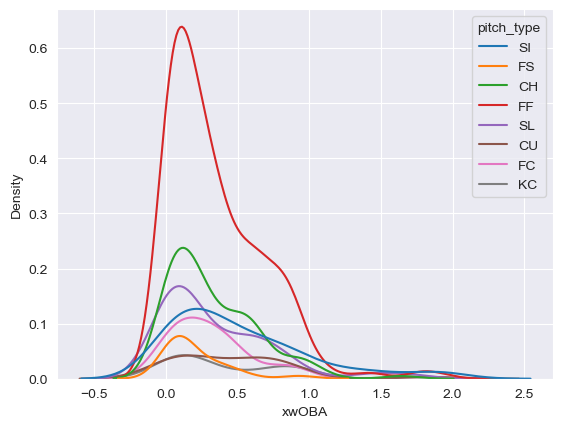

In [4]:
# sns.set(rc={"figure.figsize":(4, 7)})
sns.kdeplot(marte_vs.xwOBA, hue=marte_vs['pitch_type'])

<AxesSubplot:xlabel='xwOBA', ylabel='Count'>

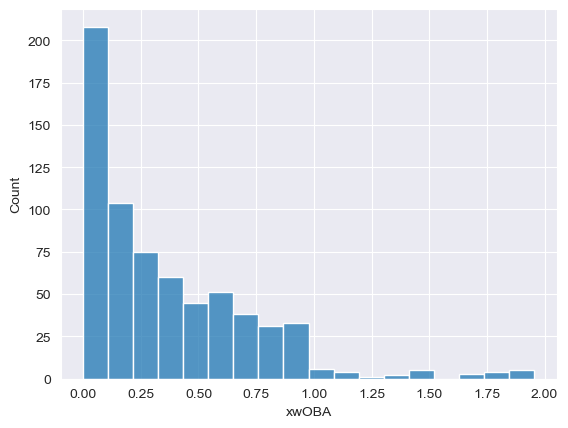

In [5]:
sns.histplot(marte_vs, x='xwOBA')  # potential need for response transformation

<AxesSubplot:ylabel='Count'>

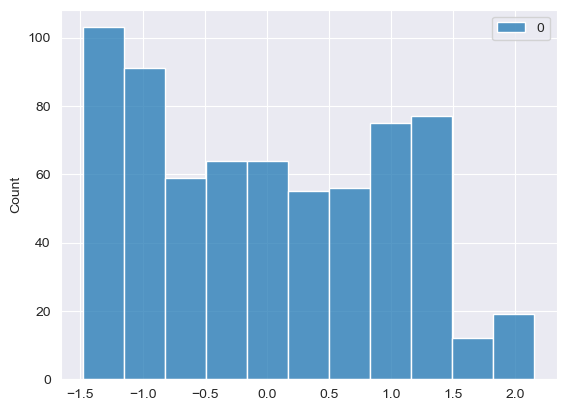

In [6]:
from sklearn.preprocessing import PowerTransformer

# Yeo-Johnson transformation of output
pt_out = PowerTransformer(standardize=True)
# extract target and convert to 1D array
y_xwOBA = marte_vs.xwOBA.to_numpy().reshape(-1, 1)
# transformation
trx_xwOBA = pt_out.fit_transform(y_xwOBA)
sns.histplot(trx_xwOBA)

<AxesSubplot:ylabel='Count'>

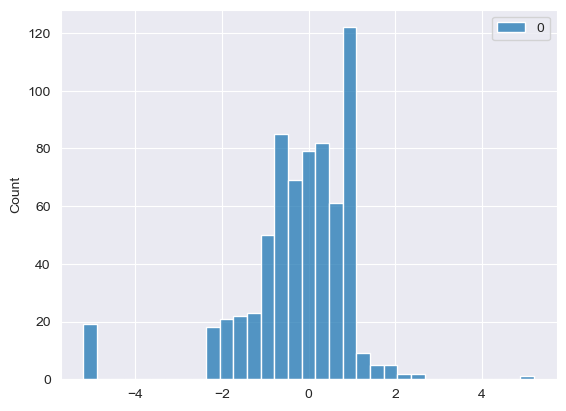

In [7]:
from sklearn.preprocessing import QuantileTransformer, quantile_transform
# qt transformation output

qt_xwOBA = quantile_transform(y_xwOBA, n_quantiles=6, output_distribution="normal", copy=True)
sns.histplot(qt_xwOBA)

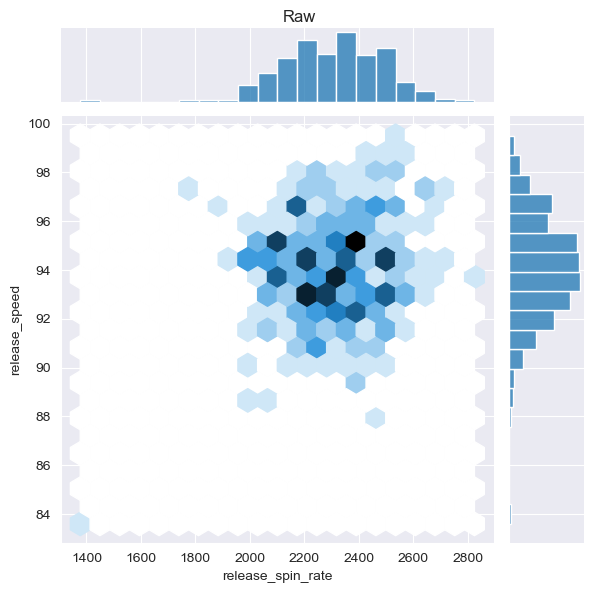

In [8]:
ff = marte_vs.groupby(['pitch_type']).get_group('FF')
g = sns.jointplot(data=ff, x='release_spin_rate', y='release_speed', kind='hex')
g.fig.suptitle("Raw")
g.fig.subplots_adjust(top=0.95)

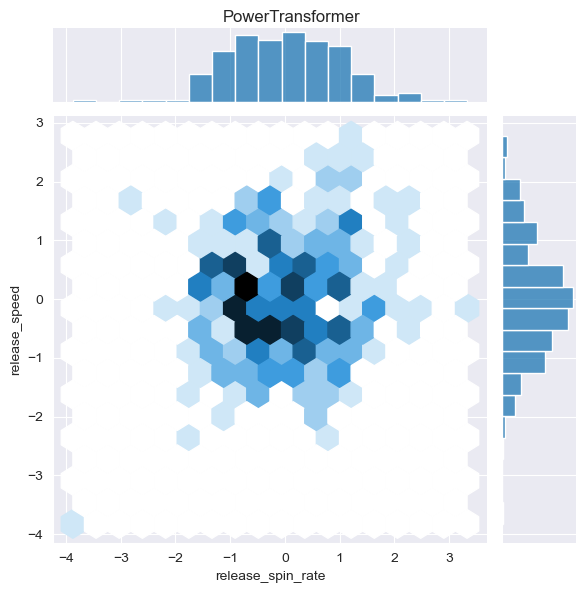

In [9]:
# used for positive values
pt = PowerTransformer(method='box-cox')
bc_trx = pt.fit_transform(ff[['release_spin_rate', 'release_speed']])
# convert to df
bc_trx = pd.DataFrame(bc_trx, columns=pt.get_feature_names_out())

g = sns.jointplot(data=bc_trx, x='release_spin_rate', y='release_speed', kind='hex')
g.fig.suptitle("PowerTransformer")
g.fig.subplots_adjust(top=0.95)

## Transformations
### Dummies
A common mistake is to apply transformations to the entire data before splitting into training and test sets. This will bias the model evaluation because information would have leaked from the test set to the training set.

In [47]:
marte_vs_trx = pd.get_dummies(data=marte_vs, columns=['pitch_type', 'zone'])
marte_vs_trx = pd.get_dummies(data=marte_vs_trx, columns=['p_throws'], drop_first=True)
marte_vs_trx.head()


,xwOBA,release_speed,release_spin_rate,pfx_x,pfx_z,pfx_v,pitch_type_CH,pitch_type_CU,pitch_type_FC,pitch_type_FF,...,zone_5,zone_6,zone_7,zone_8,zone_9,zone_11,zone_12,zone_13,zone_14,p_throws_R
0,0.709,92.9,2303.0,-1.15,0.68,1.336001,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0.262,92.6,2316.0,-1.05,0.80,1.320038,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.231,93.0,2245.0,-1.13,0.79,1.378768,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.117,93.3,2189.0,1.19,0.28,1.222497,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0.438,94.1,2126.0,-1.34,0.45,1.413542,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Feature and output transformations

In [11]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

X = marte_vs_trx.drop(columns=['xwOBA'])  # remove response var and extra features, spin_axis should be converted to categorical if desired to use in analysis, removed earlier on ingest

y = marte_vs.xwOBA
# split data into training and testing sets

X = sm.add_constant(X)   # only needed for sm (not smf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1642)

print('Train set shape\n', X_train.shape, y_train.shape)
print('Test set shape\n', X_test.shape, y_test.shape)
print('---')

# transform numerical data
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

num_feats = ['release_speed', 'release_spin_rate', 'pfx_v', 'pfx_x', 'pfx_z']
# print(X[num_feats].describe())
# used for positive values
pt = PowerTransformer()
# get a transformed series of numerical features
X_train_trx = pt.fit_transform(X_train[num_feats])
# overwrite raw numerical data
X_train[num_feats] = X_train_trx

# transform the test set with the trained lambdas
X_test_trx = pt.transform(X_test[num_feats])
# overwrite raw numerical dataframe
X_test[num_feats] = X_test_trx
############################
# # normalize output
# mms = MinMaxScaler().fit(y_train.to_numpy().reshape(-1, 1))
# y_train_trx = pd.Series(map(lambda x: x[0], mms.transform(y_train.to_numpy().reshape(-1, 1))), index=y_train.index)
# # normalize on the test output, converted to a pandas.Series with the original indicies
# y_test_trx = pd.Series(map(lambda x: x[0], mms.transform(y_test.to_numpy().reshape(-1, 1))), index=y_test.index)

print('Train trx set shape\n', X_train_trx.shape, y_train.shape)
print('Test trx set shape\n', X_test_trx.shape, y_test.shape)
print('---')

Train set shape
 (438, 28) (438,)
Test set shape
 (237, 28) (237,)
---
Train trx set shape
 (438, 5) (438,)
Test trx set shape
 (237, 5) (237,)
---


## Modeling
### Naive Model
*Note: did not transform the output for the naive model.

In [12]:
# Marte's xwOBA for last 4 seasons ('19-'22) == .348
from sklearn.metrics import *

print(y.mean())
y_same_xwOBA = pd.Series(.365, index=range(0, y_train.size))
# if squared is false then rmse
naive_rmse = mean_squared_error(y_true=y_train, y_pred=y_same_xwOBA, squared=False)
print(f"naive mse: {naive_rmse}")

naive_r2 = r2_score(y_true=y_train, y_pred=y_same_xwOBA)
print(f"naive r2 score: {naive_r2}")

0.36489185185185186
naive mse: 0.36604190443047196
naive r2 score: -0.0003866610950109539


### Classical Modeling
#### Model 1 -- OLS full feature
no spin axis feature

In [13]:
model1_feats = ['const', 'release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z', 'pfx_v', 'pitch_type_CH', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL', 'zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12', 'zone_13', 'zone_14', 'p_throws_R']
model1 = sm.OLS(endog=y_train, exog=X_train[model1_feats])
results1 = model1.fit()
print(results1.summary())
print('--------------')

                            OLS Regression Results                            
Dep. Variable:                  xwOBA   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     1.797
Date:                Mon, 12 Dec 2022   Prob (F-statistic):             0.0114
Time:                        15:36:02   Log-Likelihood:                -158.55
No. Observations:                 438   AIC:                             369.1
Df Residuals:                     412   BIC:                             475.2
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3565      0.04

model1 mse: 0.3673738968917064
model r2 score: -0.042725856800440276


/Users/tpubz/miniconda3/envs/notebooks/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='xwOBA'>

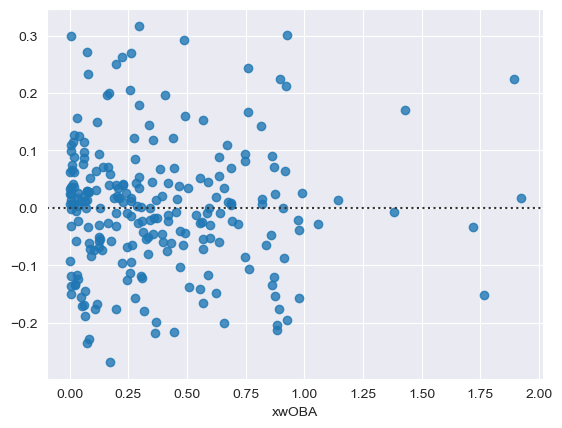

In [14]:
# model 1 evaluation
xwOBA_pred1 = results1.predict(X_test[model1_feats])

m1_mse = mean_squared_error(y_test, xwOBA_pred1, squared=False)
print(f"model1 mse: {m1_mse}")

m1_r2 = r2_score(y_test, xwOBA_pred1)
print(f"model r2 score: {m1_r2}")

# sns.scatterplot(y_test, xwOBA_pred1).set(xlabel='True', ylabel='Predicted')
sns.residplot(y_test, xwOBA_pred1)

#### Model 2 -- OLS backward selection p-val

In [15]:
# removed release_speed, p_throws_R, all zones
model2_feats = ['const', 'pitch_type_CU', 'pitch_type_SI', 'zone_13', 'zone_14']
model2 = sm.OLS(endog=y_train, exog=X_train[model2_feats])
results2 = model2.fit()
print(results2.summary())
print('--------------')

                            OLS Regression Results                            
Dep. Variable:                  xwOBA   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     7.056
Date:                Mon, 12 Dec 2022   Prob (F-statistic):           1.65e-05
Time:                        15:36:03   Log-Likelihood:                -167.39
No. Observations:                 438   AIC:                             344.8
Df Residuals:                     433   BIC:                             365.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3443      0.020     17.489

model2 mse: 0.35810213566946475
model r2 score: 0.009242485146521706


/Users/tpubz/miniconda3/envs/notebooks/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='xwOBA'>

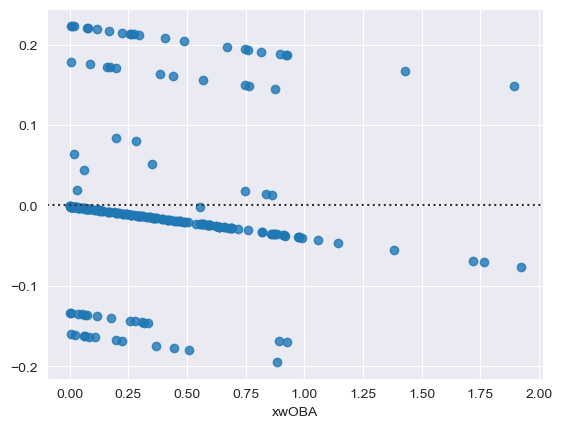

In [16]:
xwOBA_pred2 = results2.predict(X_test[model2_feats])

m2_mse = mean_squared_error(y_test, xwOBA_pred2, squared=False)
print(f"model2 mse: {m2_mse}")

m2_r2 = r2_score(y_test, xwOBA_pred2)
print(f"model r2 score: {m2_r2}")

sns.residplot(y_test, xwOBA_pred2)

#### Model 2a -- Interaction Variables --------------------------------
create a PolynomialFeatures with interactions for all variables

In [17]:
# from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
#
# cat_features = ['pitch_type', 'zone', 'p_throws']
# ohe = OneHotEncoder(sparse=False)
# # encode the 3 categorical features
# marte_vs_enc = ohe.fit_transform(marte_vs[cat_features])
# # need to keep index for proper concat
# # convert to df
# ohe_df = pd.DataFrame(marte_vs_enc, columns=ohe.get_feature_names_out(), index=marte_vs.index)
# # merge dataframes and drop redundant columns
# data = pd.concat([ohe_df, marte_vs], axis='columns').drop(columns=['pitch_type', 'zone', 'p_throws', 'game_year', 'pitcher', 'xwOBA', 'woba_value', 'spin_axis'], axis='columns')
# num_feats = ['release_speed', 'release_spin_rate', 'pfx_v']
# # normalize numerical features
# data[['release_speed', 'release_spin_rate', 'pfx_v']] = MinMaxScaler().fit_transform(data[num_feats])
# poly = PolynomialFeatures(interaction_only=True)
# # interaction dataframe with transformations
# # TODO need to not combine pitch type interactions and zone interactions with themselves
# marte_vs_inter = pd.DataFrame(poly.fit_transform(data), columns=poly.get_feature_names_out(), index=marte_vs.index)

In [18]:
# ###  Recursive Feature Elimination
# from sklearn.feature_selection import RFE
# from sklearn import linear_model
#
# scores = pd.DataFrame(columns=['scores','num features'])
# model2a = linear_model.LinearRegression()
#
# for k in range(1, marte_vs_inter.shape[1]):
#     # rfe = RFE(model, k)
#     rfe = RFE(estimator=model2a, n_features_to_select=k)
#     fit = rfe.fit(marte_vs_inter, marte_vs.xwOBA)
#     score = fit.score(marte_vs_inter, marte_vs.xwOBA)
#     run = pd.Series({'scores': score, 'features': k})
#     scores = pd.concat([scores, run.to_frame().T], ignore_index=True)
#     # f = fit.get_support(1) #the most important features
#     #
#     # # final_features = data[data.columns[f]] # final features: this gives wrong results
#     # final_features = X[X.columns[f]] # final features
#
#     print("Num Features: %d" % fit.n_features_)
#     # print("Selected Features: %s" % final_features.columns)
#     print("Score: %2.2f" % score)
#     print("----------")
#
# sns.lineplot(data=scores, x='features', y='scores')

#### Model 2b RFE

In [19]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLarsIC

scores = pd.DataFrame(columns=['test scores', 'train scores', 'num features'])

model2b = LinearRegression()

for k in range(1, 28):
    # rfe = RFE(model, k)

    rfe = RFE(estimator=model2b, n_features_to_select=k)
    fit = rfe.fit(X_train, y_train)
    train_score = fit.score(X_train, y_train)
    test_score = fit.score(X_test, y_test)
    if test_score < 0:
        continue
    run = pd.Series({'train scores': train_score, 'test scores': test_score,'num features': k})
    scores = pd.concat([scores, run.to_frame().T], ignore_index=True)

    f = fit.get_support(1) #the most important features
    final_features = X_train[X_train.columns[f]] # final features

    print("Num Features: %d" % fit.n_features_)
    print("Selected Features: %s" % final_features.columns)
    print("Test Score: %2.3f" % test_score)
    print("----------")

mod2b_feats = ['const', 'pitch_type_SI', 'pitch_type_CU', 'zone_13']
y_pred_mod2b = model2b.fit(X_train[mod2b_feats], y_train).predict(X_test[mod2b_feats])

m2b_mse = mean_squared_error(y_test, y_pred_mod2b, squared=False)
print(f"model3 mse: {m2b_mse}")

m2b_r2 = r2_score(y_test, y_pred_mod2b)
print(f"model3 r2 score: {m2b_r2}")

print(f"aic: {sm.OLS(endog=y_train, exog=X_train[mod2b_feats]).fit().aic}")

Num Features: 3
Selected Features: Index(['pitch_type_CU', 'pitch_type_SI', 'zone_13'], dtype='object')
Test Score: 0.009
----------
Num Features: 4
Selected Features: Index(['pitch_type_CU', 'pitch_type_SI', 'zone_11', 'zone_13'], dtype='object')
Test Score: 0.003
----------
Num Features: 5
Selected Features: Index(['pitch_type_CU', 'pitch_type_SI', 'zone_11', 'zone_13', 'zone_14'], dtype='object')
Test Score: 0.003
----------
Num Features: 6
Selected Features: Index(['pitch_type_CU', 'pitch_type_SI', 'zone_11', 'zone_12', 'zone_13',
       'zone_14'],
      dtype='object')
Test Score: 0.003
----------
Num Features: 7
Selected Features: Index(['pitch_type_CU', 'pitch_type_SI', 'zone_1', 'zone_11', 'zone_12',
       'zone_13', 'zone_14'],
      dtype='object')
Test Score: 0.001
----------
model3 mse: 0.35822509994620827
model3 r2 score: 0.008561960315335515
aic: 346.05990160957094


<AxesSubplot:xlabel='num features'>

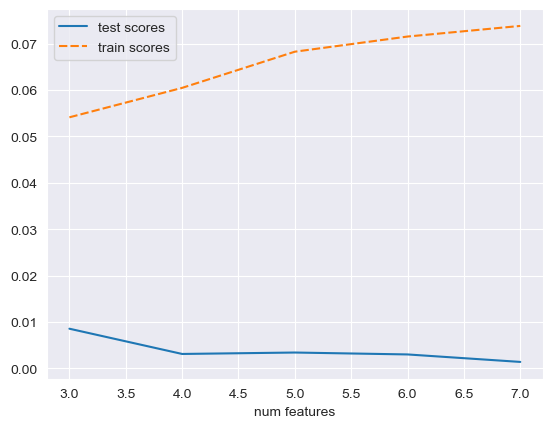

In [20]:
scores = scores.set_index('num features')
sns.lineplot(data=scores)

#### Model 3.5 LassoLarcIC regression
https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html

model3 mse: 0.35838944557911667
model r2 score: 0.007652052615336635
lowest aic: 350.6895421678478


/Users/tpubz/miniconda3/envs/notebooks/lib/python3.10/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/tpubz/miniconda3/envs/notebooks/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and pa

<AxesSubplot:xlabel='xwOBA'>

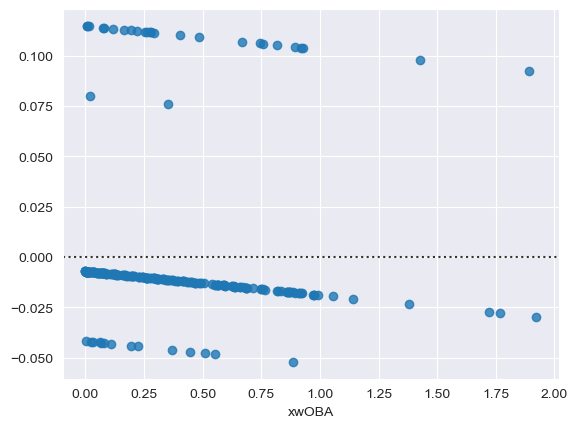

In [21]:
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline


model3_feats = ['const', 'release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z', 'pfx_v', 'pitch_type_CH', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL', 'zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12', 'zone_13', 'zone_14', 'p_throws_R']

lasso_lars_ic = make_pipeline(LassoLarsIC(criterion="aic", fit_intercept=True)).fit(X_train[model3_feats], y=y_train)

y_pred_mod3 = lasso_lars_ic.predict(X_test[model3_feats])

results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

m3_mse = mean_squared_error(y_test, y_pred_mod3, squared=False)
print(f"model3 mse: {m3_mse}")

m3_r2 = r2_score(y_test, y_pred_mod3)
print(f"model r2 score: {m3_r2}")

print(f"lowest aic: {lasso_lars_ic[-1].criterion_.min()}")

sns.residplot(y_test, y_pred_mod3)

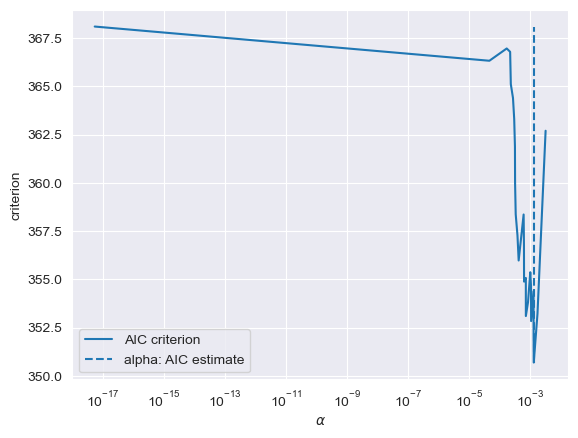

In [22]:
ax = results.plot()
ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()

In [23]:
# try groupby pitch_type
# convert pitch dummies to single column
org_pit_col_train = pd.from_dummies(X[['pitch_type_CH', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL']], sep='pitch_type_')
# drop dummy pitch_types from transformed train set
X_grp_pit = X.drop(columns=['pitch_type_CH', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL'], axis=1)
# # add back zipped column, need to use .values attribute or will have index issues
X_grp_pit['pitch_type'] = org_pit_col_train.values
# # groupby pitch_type
X_ff = X_grp_pit.groupby(['pitch_type']).get_group('FF')
X_ff = X_ff.drop(columns=['pitch_type'])

In [24]:
y = marte_vs.groupby(['pitch_type']).get_group('FF').xwOBA
X_train, X_test, y_train, y_test = train_test_split(X_ff, y, test_size=0.35, random_state=1642)

print(y.describe())
print('---')
print('Train set shape\n', X_train.shape, y_train.shape)
print('Test set shape\n', X_test.shape, y_test.shape)
print('---')

count    273.000000
mean       0.348396
std        0.336300
min        0.000000
25%        0.084000
50%        0.250000
75%        0.565000
max        1.922000
Name: xwOBA, dtype: float64
---
Train set shape
 (177, 20) (177,)
Test set shape
 (96, 20) (96,)
---


In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

num_feats = ['release_speed', 'release_spin_rate', 'pfx_v', 'pfx_x', 'pfx_z']
# used for positive values
pt = PowerTransformer()
nct = ColumnTransformer(
    transformers=[
        ('pt_pre', pt, num_feats)
    ])

# get a transformed series of numerical features
X_train_trx = pt.fit_transform(X_train[num_feats])
# overwrite raw numerical data
X_train[num_feats] = X_train_trx

# transform the test set with the trained lambdas
X_test_trx = pt.transform(X_test[num_feats])
# overwrite raw numerical dataframe
X_test[num_feats] = X_test_trx
############################
# # normalize output
# mms = MinMaxScaler().fit(y_train.to_numpy().reshape(-1, 1))
# y_train_trx = pd.Series(map(lambda x: x[0], mms.transform(y_train.to_numpy().reshape(-1, 1))), index=y_train.index)
# # normalize on the test output, converted to a pandas.Series with the original indicies
# y_test_trx = pd.Series(map(lambda x: x[0], mms.transform(y_test.to_numpy().reshape(-1, 1))), index=y_test.index)


print('Train trx set shape\n', X_train_trx.shape, y_train.shape)
print('Test trx set shape\n', X_test_trx.shape, y_test.shape)


Train trx set shape
 (177, 5) (177,)
Test trx set shape
 (96, 5) (96,)


#### Model 4 -- Single pitch filter

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
model4_feats = ['const', 'release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z', 'pfx_v']

# lm = LinearRegression()
# pl = make_pipeline(nct, lm)
#
# cv = cross_val_score(estimator=pl, X=X_ff[num_feats], y=y, cv=200, scoring='neg_root_mean_squared_error')
# cv.mean()

model4 = sm.OLS(endog=y_train, exog=X_train[model4_feats])
results4 = model4.fit()
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:                  xwOBA   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.8201
Date:                Mon, 12 Dec 2022   Prob (F-statistic):              0.537
Time:                        15:36:05   Log-Likelihood:                -55.900
No. Observations:                 177   AIC:                             123.8
Df Residuals:                     171   BIC:                             142.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3398      0.02

model2 mse: 0.3312907336468371
model r2 score: 0.021513523524541167


/Users/tpubz/miniconda3/envs/notebooks/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='xwOBA'>

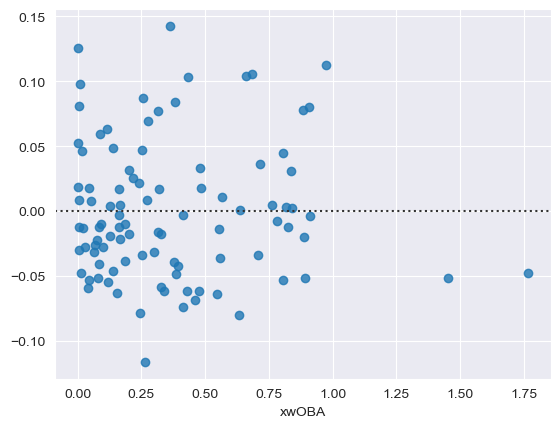

In [27]:
xwOBA_pred4 = results4.predict(X_test[model4_feats])

m4_mse = mean_squared_error(y_test, xwOBA_pred4, squared=False)
print(f"model2 mse: {m4_mse}")

m4_r2 = r2_score(y_test, xwOBA_pred4)
print(f"model r2 score: {m4_r2}")

sns.residplot(y_test, xwOBA_pred4)